# Let's try some STAC to Xarray examples

- `odc-stac`
- `stackstac`



In [1]:
from pystac_client import Client

service = "http://localhost:8000"
cat = Client.open(service)

collection_id = "ukcp"

In [243]:
resp = cat.search(collections=collection_id) #, ids="ukcp-rcp85-tasmax")
items = list(resp.items())
print(f"Found {len(items)} items")

Found 2 items


In [2]:
item = next(cat.search(ids="ukcp-rcp85-tasmax").items())
item.properties

{'datetime': '2030-12-01T12:00:00+00:00'}

You can validate with: `item.validate()`

And convert to a dictionary with: `item.to_dict()`

## Write a function to map our STAC record Kerchunk reference to Xarray

There _must_ be a nicer way!

In [4]:
import fsspec
import xarray as xr

def stac_item_to_xarray(item, key=None):
    index_uri = item.assets[list(item.assets.keys())[0]].href
    mapper = fsspec.get_mapper("reference://", fo=index_uri) 
    return xr.open_zarr(mapper, consolidated=False)

In [5]:
ds = stac_item_to_xarray(item)
ds

<xarray.Dataset>
Dimensions:                       (ensemble_member: 1, time: 21600,
                                   projection_y_coordinate: 244,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * ensemble_member               (ensemble_member) float64 1.0
    ensemble_member_id            (time, ensemble_member) object dask.array<chunksize=(1, 1), meta=np.ndarray>
    latitude                      (time, projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(1, 244, 180), meta=np.ndarray>
    longitude                     (time, projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(1, 244, 180), meta=np.ndarray>
    month_number                  (time) float64 dask.array<chunksize=(3600,), meta=np.ndarray>
  * projection_x_coordinate       (projection_x_coordinate) float64 -1.975e+0...
  * projection_y_coordinate       (projection_y_coordinate) float64 -3.25e+04...
  * time                          (time) object 1980-12-01 12:00:00 ... 2080-...
    year                          (time) float64 dask.array<chunksize=(3600,), meta=np.ndarray>
    yyyymmdd                      (time) object dask.array<chunksize=(3600,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float64 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float64 dask.array<chunksize=(1, 244, 2), meta=np.ndarray>
    tasmax                        (ensemble_member, time, projection_y_coordinate, projection_x_coordinate) float32 dask.array<chunksize=(1, 3600, 244, 180), meta=np.ndarray>
    time_bnds                     (time, bnds) object dask.array<chunksize=(3600, 2), meta=np.ndarray>
    transverse_mercator           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/15)
    Conventions:     CF-1.7
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2021-06-09T16:58:11
    domain:          uk
    frequency:       day
    ...              ...
    references:      https://ukclimateprojections.metoffice.gov.uk
    resolution:      5km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - Regridded 2.2km convection-per...
    version:         v20210615

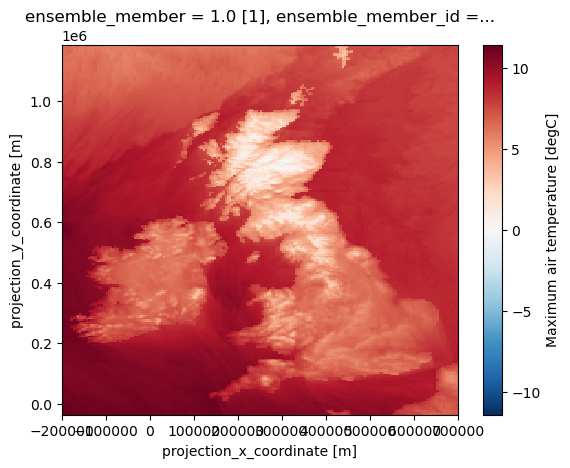

In [6]:
ds.tasmax.isel(time=slice(0, 1)).plot()

## Reading Sentinel data in Slack



In [7]:
from pystac_client import Client

service = "http://localhost:8000"
cat = Client.open(service)

collection_id = "uk-sentinel-2"

In [8]:
resp = cat.search(collections=collection_id, datetime=("2020-01-01", "2030-01-02"))

In [9]:
item = next(resp.items())

In [10]:
item

<Item id=S2B_30VUL_20230630T120359>

## Comparing content of our STAC item and a Planetary Computer STAC item

...because ours does not contain all properties, something in the pystac library is not working as expected...

In [11]:
import requests
resp1 = requests.get("http://localhost:8000/collections/ukcp/items/ukcp-rcp85-tasmax")
resp2 = requests.get("https://planetarycomputer.microsoft.com/api/stac/v1/collections/nasa-nex-gddp-cmip6/items/UKESM1-0-LL.ssp585.2100")
u = resp1.json()
p = resp2.json()

In [12]:
sorted(u.keys()) == sorted(p.keys())

True

In [13]:
for key in u.keys():
    print(f"{key}: {u[key]} VERSUS {p[key]}")

type: Feature VERSUS Feature
stac_version: 1.0.0 VERSUS 1.0.0
stac_extensions: [] VERSUS ['https://stac-extensions.github.io/datacube/v2.0.0/schema.json']
id: ukcp-rcp85-tasmax VERSUS UKESM1-0-LL.ssp585.2100
collection: ukcp VERSUS nasa-nex-gddp-cmip6
geometry: {'type': 'Polygon', 'bbox': [-12.773760066441621, 49.31371471134698, 3.4064378554829906, 60.526678613029915], 'coordinates': [[[-12.773760066441621, 49.31371471134698], [3.4064378554829906, 49.31371471134698], [3.4064378554829906, 60.526678613029915], [-12.773760066441621, 60.526678613029915], [-12.773760066441621, 49.31371471134698]]]} VERSUS {'type': 'Polygon', 'coordinates': [[[180, -90], [180, 90], [-180, 90], [-180, -90], [180, -90]]]}
bbox: [-12.773760066441621, 49.31371471134698, 3.4064378554829906, 60.526678613029915] VERSUS [-180, -90, 180, 90]
properties: {'start_datetime': '1980-12-01T12:00:00+00:00', 'end_datetime': '2080-11-30T12:00:00+00:00', 'proj:epsg': 32701, 'ukcp:collection': 'land-cpm', 'contact': 'ukcpprojec

In [14]:
import pystac.item

In [15]:
# In progress, could try instantiating the Pystac item:
# pystac.item.Item(u["geometry"], u['bbox'], u['properties']['datetime'], u['properties'], u["properties"])

In [16]:
#pystac.item.Item(u["geometry"], u['bbox'], u['properties']['datetime'], u['properties'], u["properties"])